# Intramarket Indicator Differences Crypto Trading Strategy in Python

Using the difference between an indicator measured on two different symbols to build a trading strategy for Ethereum.

* Tutorial: [Intramarket Indicator Differences | Algorithmic Crypto Trading Strategy in Python](https://www.youtube.com/watch?v=n2mY86S01fg)
* Code: https://github.com/neurotrader888/IntramarketDifference

Links

- https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk

In [1]:
import pandas as pd
import numpy as np
import scipy
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
from tqdm import tqdm

### ETH BTC Comparison

In [2]:
btc_data = pd.read_csv('src/BTCUSDT3600.csv')
btc_data['date'] = btc_data['date'].astype('datetime64[s]')
btc_data = btc_data.set_index('date')
btc_data = btc_data.dropna()

eth_data = pd.read_csv('src/ETHUSDT3600.csv')
eth_data['date'] = eth_data['date'].astype('datetime64[s]')
eth_data = eth_data.set_index('date')
eth_data = eth_data.dropna()

In [3]:
# Get log diff of eth and btc
eth_data['diff'] = np.log(eth_data['close']).diff()
btc_data['diff'] = np.log(btc_data['close']).diff()

Correlation 0.839484062282371


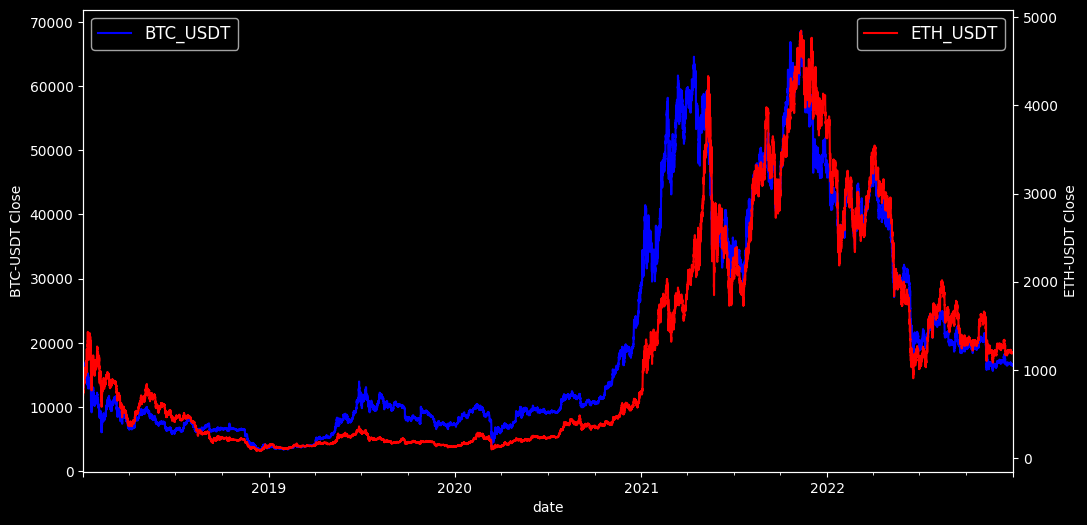

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))

# Plot cumulative sum of log returns for both btc and eth.
ax = plt.gca()
btc_data['close'].plot(color='blue', label='BTC_USDT', ax=ax)
ax2 = plt.twinx()
eth_data['close'].plot(color='red', label='ETH_USDT', ax=ax2)
ax.legend(loc='upper left', fontsize='large')
ax2.legend(loc='upper right', fontsize='large')
ax.set_ylabel("BTC-USDT Close")
ax2.set_ylabel("ETH-USDT Close")
print("Correlation", eth_data['diff'].corr(btc_data['diff']))
plt.show()

### Intramarket Indicator Differences

In [5]:
def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal.iloc[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal.iloc[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal.iloc[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal.iloc[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal.iloc[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['return'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['return'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    
    long_trades['type'] = 1
    short_trades['type'] = -1
    all_trades = pd.concat([long_trades, short_trades])
    all_trades = all_trades.sort_index()
    
    return long_trades, short_trades, all_trades

In [6]:
def cmma(ohlc: pd.DataFrame, lookback: int, atr_lookback: int = 168):
    # cmma = Close minus moving average
    atr = ta.atr(ohlc['high'], ohlc['low'], ohlc['close'], atr_lookback)
    ma = ohlc['close'].rolling(lookback).mean()
    ind = (ohlc['close'] - ma) / (atr * lookback ** 0.5)
    return ind

def threshold_revert_signal(ind: pd.Series, threshold: float):
    # Outputs a 1 or -1 signal once the indicator goes above threshold or below -threshold
    # Outputs 0 again once the indicator returns to 0

    signal = np.zeros(len(ind))
    position = 0
    for i in range(len(ind)):
        if ind.iloc[i] > threshold:
            position = 1
        if ind.iloc[i] < -threshold:
            position = -1

        if position == 1 and ind.iloc[i] <= 0:
            position = 0
        
        if position == -1 and ind.iloc[i] >= 0:
            position = 0

        signal[i] = position
    
    return signal

In [7]:
btc_data = pd.read_csv('src/BTCUSDT3600.csv')
btc_data['date'] = btc_data['date'].astype('datetime64[s]')
btc_data = btc_data.set_index('date')
btc_data = btc_data.dropna()
    
eth_data = pd.read_csv('src/ETHUSDT3600.csv')
eth_data['date'] = eth_data['date'].astype('datetime64[s]')
eth_data = eth_data.set_index('date')
eth_data = eth_data.dropna()

In [8]:
# Get log diff of eth and btc
eth_data['diff'] = np.log(eth_data['close']).diff()
btc_data['diff'] = np.log(btc_data['close']).diff()

eth_data['next_return'] = eth_data['diff'].shift(-1)
btc_data['next_return'] = btc_data['diff'].shift(-1)

Profit factor 1.0784597650993482


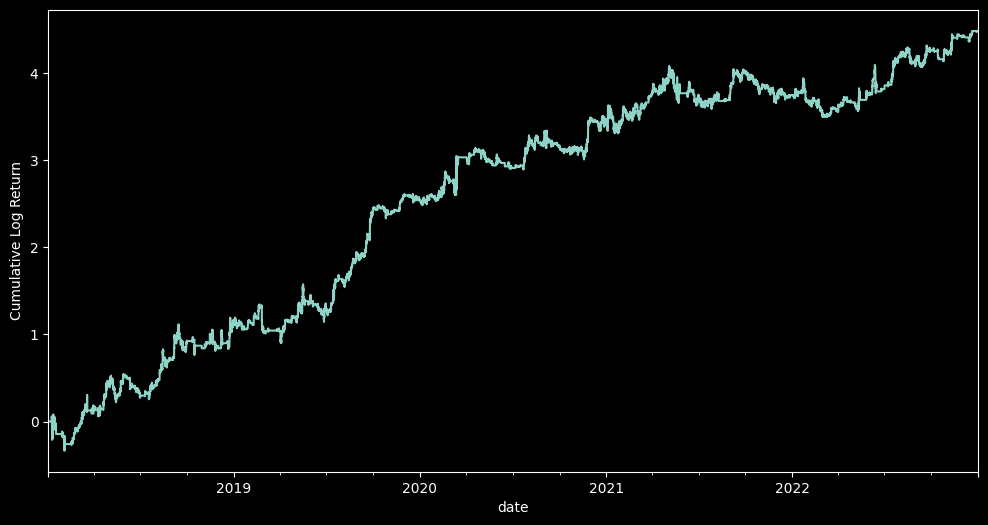

In [9]:
lookback = 24
threshold = 0.25
atr_lookback = 168
btc_cmma = cmma(btc_data, lookback, atr_lookback)
eth_cmma = cmma(eth_data, lookback, atr_lookback)

intermarket_diff = eth_cmma - btc_cmma

eth_data['sig'] = threshold_revert_signal(intermarket_diff, threshold)

plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
rets = eth_data['sig'] * eth_data['next_return']
pf = rets[rets > 0].sum() / rets[rets<0].abs().sum()
print("Profit factor", pf)
rets.cumsum().plot()
plt.ylabel("Cumulative Log Return")
plt.show()

In [10]:
long_trades, short_trades, all_trades = get_trades_from_signal(eth_data, eth_data['sig'])

long_tr = long_trades['return']
short_tr = short_trades['return']

print("long trades")
print("# of trades", len(long_tr))
print("win rate", len(long_tr[long_tr > 0]) / len(long_tr) )
print("avg trade %", long_tr.mean() * 100)
print("") 
print("short trades")
print("# of trades", len(short_tr))
print("win rate", len(short_tr[short_tr > 0]) / len(short_tr) )
print("avg trade %", short_tr.mean() * 100)

long trades
# of trades 389
win rate 0.5115681233933161
avg trade % 0.5408343101268714

short trades
# of trades 373
win rate 0.517426273458445
avg trade % 0.6521458819034093


In [11]:
pf_df = pd.DataFrame()
for lookback in tqdm(range(6, 73, 3)):
    for threshold in np.linspace(0.05, 0.5, 19): 
        atr_lookback = 168
        btc_cmma = cmma(btc_data, lookback, atr_lookback)
        eth_cmma = cmma(eth_data, lookback, atr_lookback)

        intermarket_diff = eth_cmma - btc_cmma

        eth_data['sig'] = threshold_revert_signal(intermarket_diff, threshold) 

        rets = eth_data['sig'] * eth_data['next_return']

        pf = rets[rets > 0].sum() / rets[rets<0].abs().sum()
        #print(lookback, threshold, pf)
        pf_df.loc[lookback, round(threshold, 3)] = pf

100%|████████████████████████████████████████████████████████████████████| 23/23 [01:34<00:00,  4.09s/it]


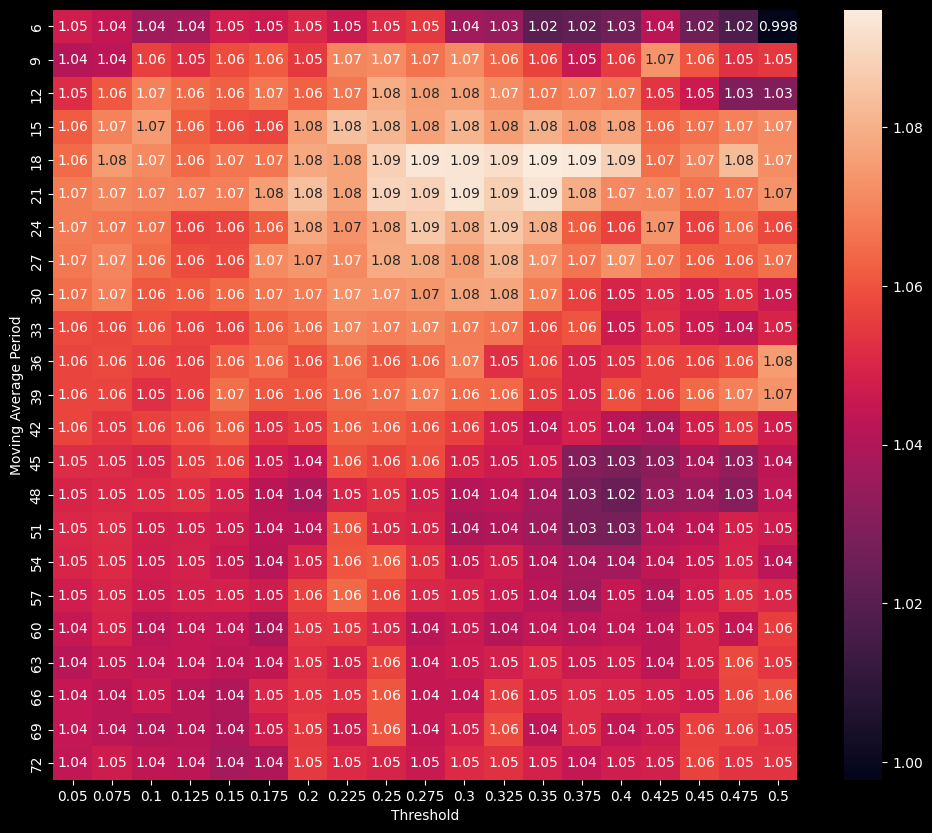

In [12]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 10))
sns.heatmap(pf_df, annot=True, fmt='0.3g')
plt.xlabel('Threshold')
plt.ylabel('Moving Average Period')
plt.show()